In [1]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import subplots
import mlxtend as mlx
import numpy as np
import pandas as pd
import statsmodels
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats import descriptivestats
from IPython.display import display, HTML, Image
import plotly.io as pio
import plotly.express as px
import json
from urllib.request import urlopen
from collections import Counter
import string
import re
import scipy
import scipy.cluster
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 50
pio.templates.default = "plotly_dark"

# Convert scientific notation to plain numbers
pd.options.display.float_format = '{:.2f}'.format

def display_side_by_side(*args):
    html_str = '<div style="display: flex; justify-content: flex-start;">'
    for df in args:
        if isinstance(df, pd.Series):
            df = df.to_frame()
        html_str += f'<div style="flex: 1; padding: 0;">{df.to_html(index=True)}</div>'
    html_str += '</div>'
    
    display(HTML(html_str))

In [2]:
#Read the parquet file that we generated on the category clustering notebook
df = pd.read_parquet('notebook referenced files\\Sales with Stock Categories.parquet')
display_side_by_side(df.head())
display_side_by_side(df.tail())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str,Label,Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30,2010-12-01,8,17850,3.00,Misc - Other
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,6.00,Bases and Holders
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00,2010-12-01,8,17850,3.00,Misc - Other
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,3.00,Misc - Other
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,3.00,Misc - Other


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str,Label,Category
527752,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France,10.20,2011-12-09,12,12680,10.00,Misc - Designed
527753,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France,12.60,2011-12-09,12,12680,10.00,Misc - Designed
527754,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680,10.00,Misc - Designed
527755,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680,10.00,Misc - Designed
527756,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.00,France,14.85,2011-12-09,12,12680,10.00,Misc - Designed


- In this notebook we will focus here on identifying customer segments to see what insights can be gained from segmentation through metrics such as average item purchase quantity, average order total, and purchase frequency

In [3]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str,Label,Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30,2010-12-01,8,17850,3.00,Misc - Other
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,6.00,Bases and Holders
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00,2010-12-01,8,17850,3.00,Misc - Other
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,3.00,Misc - Other
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,3.00,Misc - Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527752,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France,10.20,2011-12-09,12,12680,10.00,Misc - Designed
527753,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France,12.60,2011-12-09,12,12680,10.00,Misc - Designed
527754,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680,10.00,Misc - Designed
527755,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680,10.00,Misc - Designed


In [4]:
#First let's get the subset of data that we need
customers_df = df[['InvoiceNo', 'StockCode', 'Quantity', 'TotalPrice', 'InvoiceDay', 'CustomerID_str', 'Category']]
customers_with_id = customers_df[~(customers_df['CustomerID_str'] =='nan')]
customers_with_id

#Initialize some date variables to be used later
df_last_date = df.iat[-1, 9]
df_first_date = df.iat[0, 9]
df_date_delta = df_last_date - df_first_date

In [5]:
#Group the dataframe that is to be analyzed with the information that we plan on clustering
customers_with_id_filtered = customers_with_id[['Quantity', 'TotalPrice','CustomerID_str', 'InvoiceNo','InvoiceDay', 'StockCode']].groupby(['CustomerID_str', 'InvoiceNo','InvoiceDay', 'StockCode']).sum()
customers_with_id_filtered
customer_with_id_reset = customers_with_id_filtered.reset_index(level=['InvoiceNo', 'InvoiceDay', 'StockCode'])
customer_with_id_reset

#Initialize a dictionary that will be used to store calculations on customer transaction statistics
customer_stats_dict = {}
customer_list = list(set(customer_with_id_reset.index))
customer_reindexed = customer_with_id_reset.reset_index()

In [6]:
#Gather data on each customer by iteration, store calculations on totals, averages, ordering tendencies and recency.
for customer in customer_list:
    cust_df = customer_reindexed[customer_reindexed['CustomerID_str'] == customer]
    num_orders = len(np.unique(cust_df['InvoiceNo']))
    num_order_days =  len(np.unique(cust_df['InvoiceDay']))
   
    days_since_last = df_last_date - cust_df.iat[-1, 2]
    days_since_last_num = days_since_last.days
    days_since_first = df_last_date - cust_df.iat[0, 2]
    days_since_first_num = days_since_first.days
        
    total_quantity = np.sum(cust_df['Quantity'])
    total_purchases = np.sum(cust_df['TotalPrice'])

    average_quantity = total_quantity/num_orders
    average_total = total_purchases /num_orders

    unique_orders = cust_df['InvoiceNo'].unique()
    unique_items_purchased = []

    for order in unique_orders:
        transactions_df = cust_df[cust_df['InvoiceNo'] == order]
        unique_items_purchased.append(len(np.unique(transactions_df['StockCode'])))

    total_unique_stock_purchased = len(np.unique(cust_df['StockCode']))
    total_unique_stock_per_order = np.sum(unique_items_purchased)
    average_unique_stock_per_order = total_unique_stock_per_order/num_orders

    customer_stats_dict[customer] = [num_orders, num_order_days, days_since_last_num, average_unique_stock_per_order, average_quantity, average_total, total_unique_stock_purchased, total_quantity,total_purchases]


In [7]:
#Create a dataframe out of the dictionary from the previous cell
customer_stats = pd.DataFrame(customer_stats_dict)
customer_stats_df = customer_stats.T
customer_stats_df.columns = ['num_orders', 'num_order_days', 'days_since_last', 'ave_stock_per_order', 'ave_qty', 'ave_purchased', 'total_unique_stock', 'total_qty', 'total_purchases']
customer_stats_df

,num_orders,num_order_days,days_since_last,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases
13854,25.00,25.00,8.00,4.40,91.84,324.38,39.00,2296.00,8109.52
16903,1.00,1.00,29.00,50.00,262.00,373.24,50.00,262.00,373.24
17125,1.00,1.00,50.00,34.00,291.00,259.35,34.00,291.00,259.35
13328,1.00,1.00,316.00,17.00,680.00,1308.48,17.00,680.00,1308.48
12910,8.00,6.00,23.00,9.38,211.50,384.38,48.00,1692.00,3075.04
...,...,...,...,...,...,...,...,...,...
14082,1.00,1.00,364.00,28.00,110.00,182.25,28.00,110.00,182.25
16177,1.00,1.00,50.00,15.00,95.00,331.95,15.00,95.00,331.95
12508,2.00,2.00,26.00,32.00,136.00,199.13,57.00,272.00,398.27
13722,3.00,2.00,131.00,28.33,467.00,791.80,75.00,1401.00,2375.41


- Create a custom metric that tries to capture customer activity by dividing each customer's total number of orders by how recent their last order was, making sure both columns are on the same scale first which should help give equal weight to both values. 
- A higher number of order will produce higher numerator values while more recent order dates will minimize the denominator - both instances will generate higher scores for more active accounts 

In [8]:
customer_activity = customer_stats_df[['num_orders', 'days_since_last']]
mm_scaler = MinMaxScaler(feature_range=(1,100)).set_output(transform='pandas')
customer_activity_scaled = mm_scaler.fit_transform(customer_activity)
customer_activity_scaled['customer_activity_score'] = customer_activity_scaled['num_orders']/customer_activity_scaled['days_since_last']

#Add this new column to the main df
score_dict = customer_activity_scaled['customer_activity_score'].to_dict()
customer_stats_df['customer_activity_score'] = customer_stats_df.index.map(score_dict)
customer_stats_df

,num_orders,num_order_days,days_since_last,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases,customer_activity_score
13854,25.00,25.00,8.00,4.40,91.84,324.38,39.00,2296.00,8109.52,4.03
16903,1.00,1.00,29.00,50.00,262.00,373.24,50.00,262.00,373.24,0.11
17125,1.00,1.00,50.00,34.00,291.00,259.35,34.00,291.00,259.35,0.07
13328,1.00,1.00,316.00,17.00,680.00,1308.48,17.00,680.00,1308.48,0.01
12910,8.00,6.00,23.00,9.38,211.50,384.38,48.00,1692.00,3075.04,0.62
...,...,...,...,...,...,...,...,...,...,...
14082,1.00,1.00,364.00,28.00,110.00,182.25,28.00,110.00,182.25,0.01
16177,1.00,1.00,50.00,15.00,95.00,331.95,15.00,95.00,331.95,0.07
12508,2.00,2.00,26.00,32.00,136.00,199.13,57.00,272.00,398.27,0.19
13722,3.00,2.00,131.00,28.33,467.00,791.80,75.00,1401.00,2375.41,0.05


In [9]:
from statsmodels.stats import descriptivestats
#Get an overview of the numerical columns we plan on using as features for our clusters
stats_df = descriptivestats.describe(customer_stats_df[['customer_activity_score', 'total_unique_stock', 'total_qty', 'total_purchases']])
display_side_by_side(stats_df[:15].round(2), stats_df[15:].round(2))

,customer_activity_score,total_unique_stock,total_qty,total_purchases
nobs,4334.00,4334.00,4334.00,4334.00
missing,0.00,0.00,0.00,0.00
mean,0.69,61.43,1189.98,2021.47
std_err,0.04,1.30,76.60,135.30
upper_ci,0.77,63.97,1340.11,2286.67
lower_ci,0.61,58.89,1039.84,1756.28
std,2.82,85.31,5042.96,8907.50
iqr,0.41,61.00,831.75,1326.06
iqr_normal,0.30,45.22,616.58,983.01
mad,0.89,50.10,1306.40,2204.75


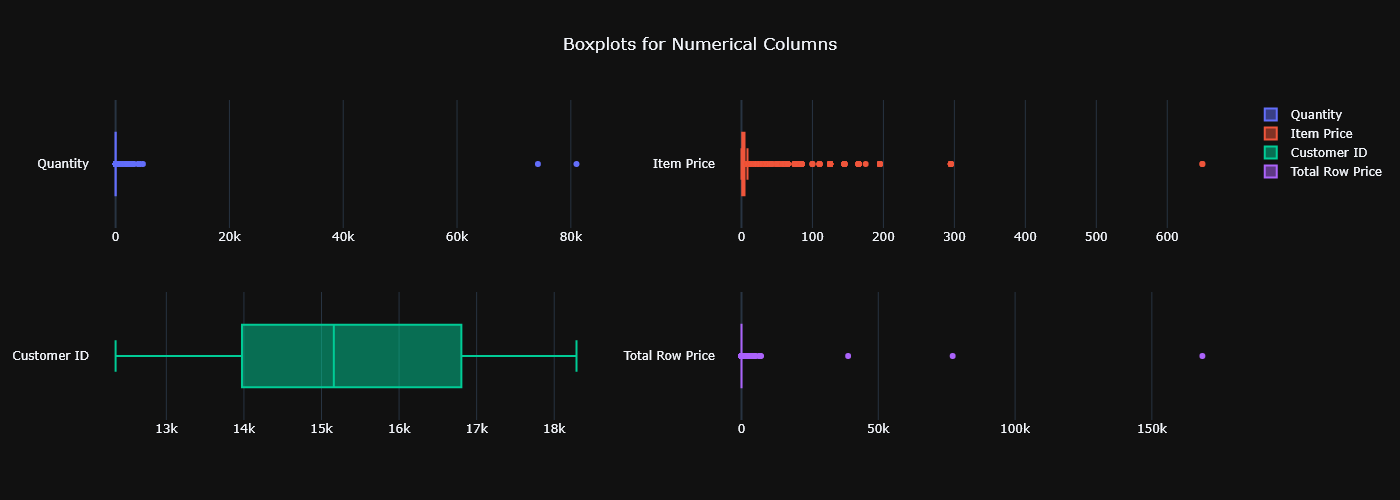

In [10]:
#Let's create some boxplots to see how our values are distributed
fig = subplots.make_subplots(rows=2, cols=2, vertical_spacing=0.2)

hist1 = go.Box(x=customer_stats_df['customer_activity_score'], name='customer_activity_score')
hist2 = go.Box(x=customer_stats_df['total_unique_stock'], name ='total_unique_stock')
hist3 = go.Box(x=customer_stats_df['total_qty'], name='total_qty')
hist4 = go.Box(x=customer_stats_df['total_purchases'], name='total_purchases')

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 1,2)
fig.append_trace(hist3, 2,1)
fig.append_trace(hist4, 2,2)

fig.update_layout(title = 'Boxplots for Numerical Columns', title_x = 0.5, width=1600)


#pio.write_image(fig, 'boxplot_num.png')
Image('boxplot_num.png')

In [11]:
#Extreme outliers can be seen from the graphs above so we will filter those out
customer_stats_no_outliers = customer_stats_df[(customer_stats_df['customer_activity_score'] < 60) & (customer_stats_df['total_unique_stock'] < 1000) & (customer_stats_df['total_qty'] < 100000) & (customer_stats_df['total_purchases'] < 200000)]
customer_stats_no_outliers.sort_values(by='customer_activity_score', ascending=False)

,num_orders,num_order_days,days_since_last,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases,customer_activity_score
15311,91.00,90.00,0.00,25.90,419.71,667.78,567.00,38194.00,60767.90,44.46
14606,90.00,88.00,1.00,29.52,69.04,133.41,816.00,6214.00,12006.65,34.76
13089,97.00,66.00,2.00,18.68,320.31,606.45,636.00,31070.00,58825.83,30.94
13408,62.00,41.00,1.00,7.71,261.81,453.50,234.00,16232.00,28117.04,24.07
12971,86.00,71.00,3.00,3.55,108.01,130.12,94.00,9289.00,11189.91,23.41
...,...,...,...,...,...,...,...,...,...,...
14237,1.00,1.00,373.00,9.00,38.00,161.00,9.00,38.00,161.00,0.01
17968,1.00,1.00,373.00,74.00,160.00,277.35,74.00,160.00,277.35,0.01
12791,1.00,1.00,373.00,1.00,96.00,177.60,1.00,96.00,177.60,0.01
15350,1.00,1.00,373.00,5.00,51.00,115.65,5.00,51.00,115.65,0.01


- Create a 3D Scatter Plot of the three main metrics we plan to use as features in clustering customers, with outliers removed

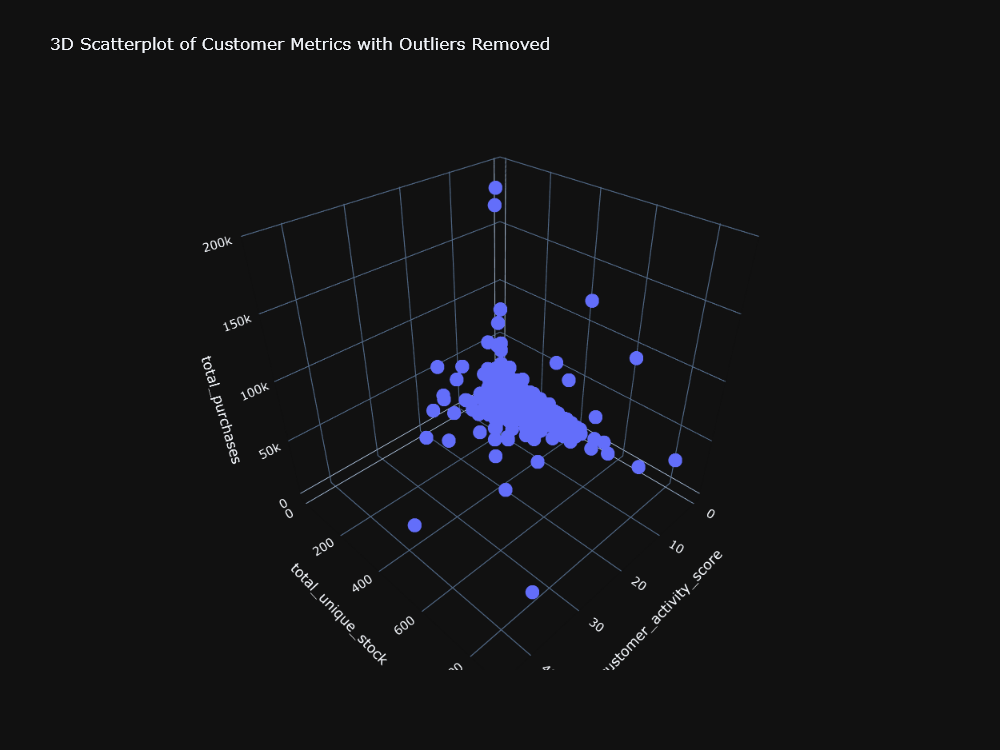

In [12]:
scatter_no_outlier = px.scatter_3d(data_frame=customer_stats_no_outliers, x='customer_activity_score', y='total_unique_stock', z='total_purchases', title='3D Scatterplot of Customer Metrics with Outliers Removed', height=750, width = 1000)
#pio.write_image(scatter_no_outlier, 'scatter_no_outlier.png')
Image('scatter_no_outlier.png')

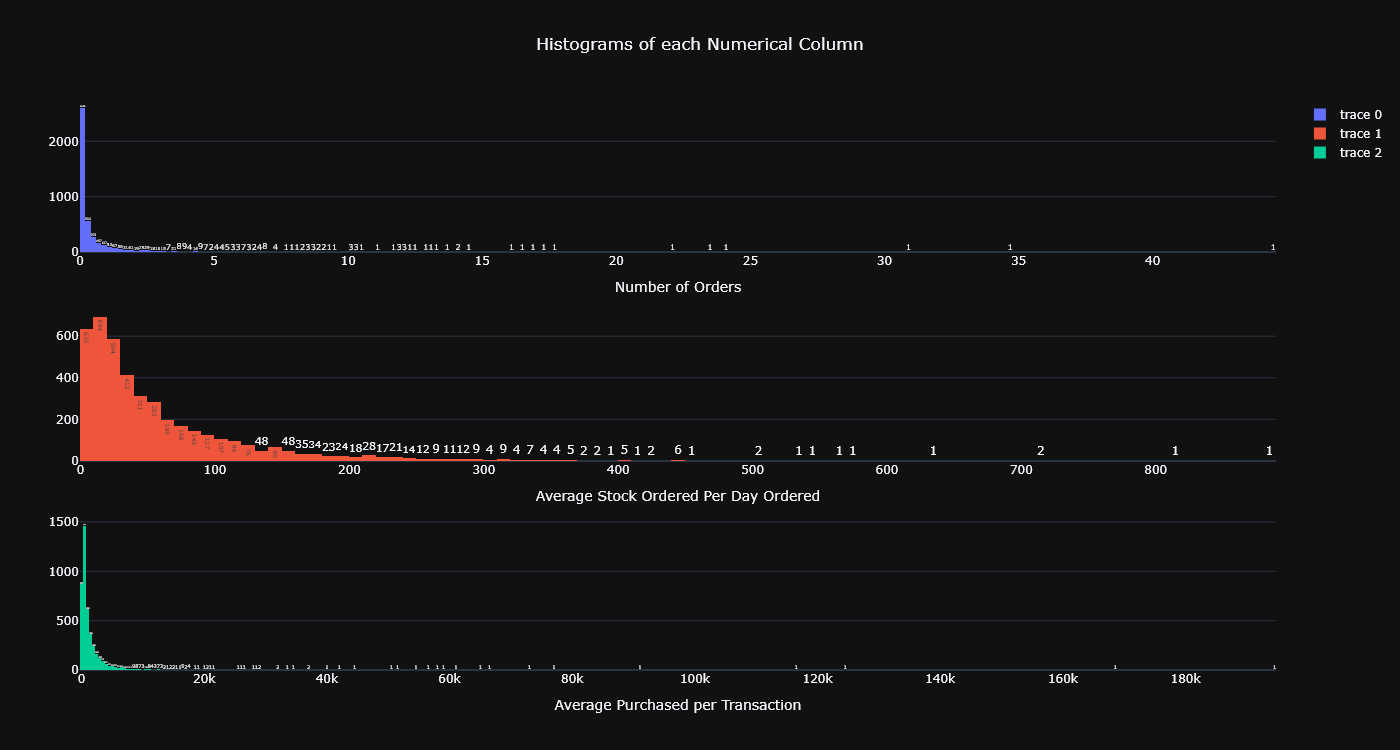

In [13]:
#Create histograms to show the distribution of each column after removing outliers above
fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.1)

hist1 = go.Histogram(x=customer_stats_no_outliers['customer_activity_score'], texttemplate='%{y}')  
                    # xbins=dict(start=0, end = float(top_percentile['UnitPrice']), size=1), name='Item Price')
hist2 = go.Histogram(x=customer_stats_no_outliers['total_unique_stock'], texttemplate='%{y}')
                    # xbins=dict(size=100), name='Customer ID Counts')
hist3 = go.Histogram(x=customer_stats_no_outliers['total_purchases'],  texttemplate='%{y}')
                      #xbins=dict(start=0, end = float(top_percentile['TotalPrice']), size=10), name='Total Row Price')

# Update x-axis labels
fig.update_xaxes(title_text='Number of Orders', row=1, col=1)
fig.update_xaxes(title_text='Average Stock Ordered Per Day Ordered', row=2, col=1)
fig.update_xaxes(title_text=f'Average Purchased per Transaction', row=3, col=1)

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 2,1)
fig.append_trace(hist3, 3,1)

fig.update_layout(title = 'Histograms of each Numerical Column', title_x = 0.5, width =1400, height = 750)
#pio.write_image(fig, 'hist_clust.png')
Image('hist_clust.png')

In [14]:
import scipy.stats as stats
from pingouin import multivariate_normality

#Let's run some tests
stat, p_value = stats.bartlett(customer_stats_no_outliers['customer_activity_score'], customer_stats_no_outliers['total_unique_stock'], customer_stats_no_outliers['total_purchases'])
print(stat, p_value)


result = multivariate_normality(customer_stats_no_outliers[['customer_activity_score', 'total_unique_stock', 'total_purchases']], alpha=0.05)
print(result)

95012.30508112704 0.0
HZResults(hz=1185.6840047488204, pval=0.0, normal=False)


- The results from the Bartlett test (high test statistic) indicate that the variances among our data are not equal while the result for the second test of multivariate normality outputting normal = False means that the test is violated

- In order to address the results of our tests above and help improve our model's ability to cluster, we will use Quantile Transformer to scale and standardize our data as it can force distributions to be normal - which will help align our data to the assumptions needed for using Gaussian Mixture

In [15]:


from sklearn.preprocessing import QuantileTransformer


scaler = QuantileTransformer(n_quantiles=1000, output_distribution='normal').set_output(transform="pandas")
customer_stats_scaled = scaler.fit_transform(customer_stats_no_outliers[['customer_activity_score', 'total_unique_stock', 'total_purchases']])
customer_stats_scaled

,customer_activity_score,total_unique_stock,total_purchases
13854,1.87,0.08,1.90
16903,-0.02,0.28,-0.46
17125,-0.29,-0.03,-0.81
13328,-1.74,-0.62,0.51
12910,0.83,0.25,1.17
...,...,...,...
14082,-2.13,-0.20,-1.11
16177,-0.29,-0.71,-0.57
12508,0.24,0.41,-0.40
13722,-0.45,0.65,0.97


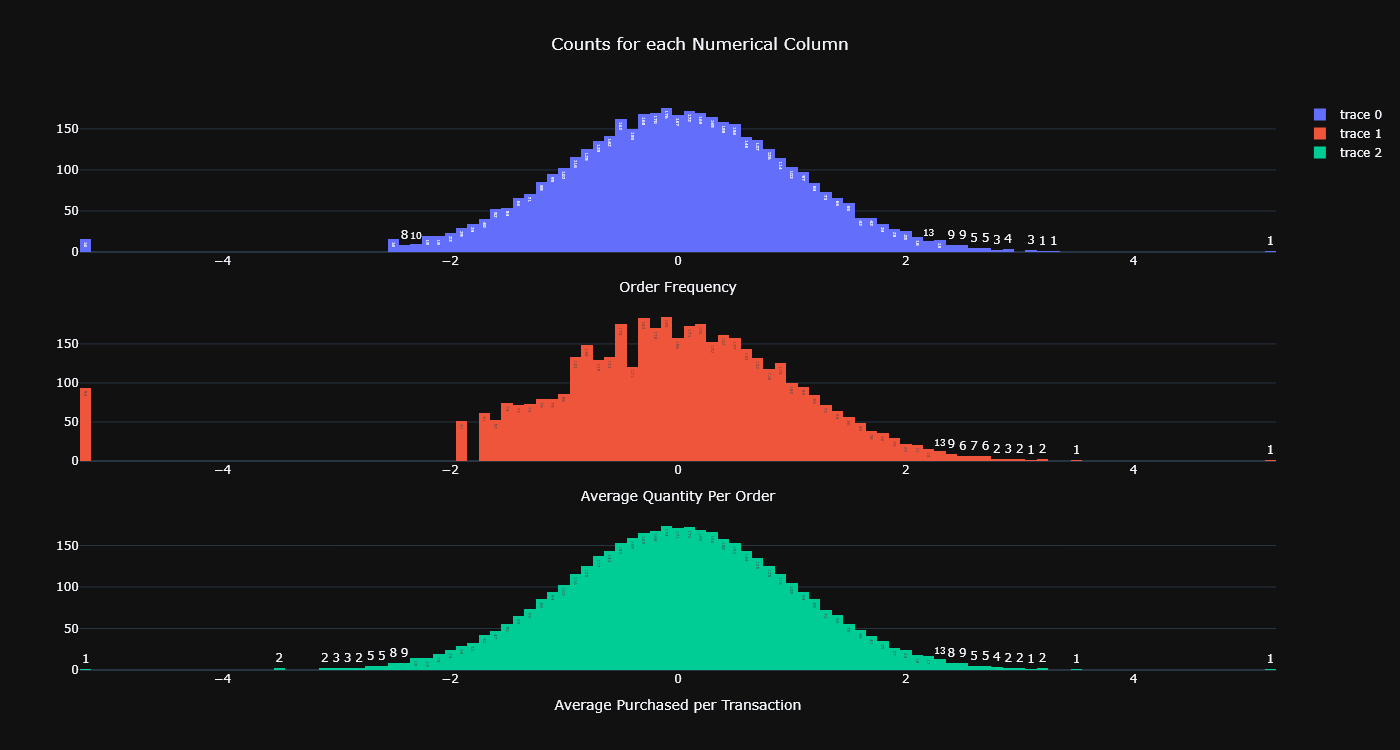

In [16]:
#Let's see the effects of applying a Quantile Transform on the distribution of our data
fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.1)

hist1 = go.Histogram(x=customer_stats_scaled['customer_activity_score'], texttemplate='%{y}')  
                    # xbins=dict(start=0, end = float(top_percentile['UnitPrice']), size=1), name='Item Price')
hist2 = go.Histogram(x=customer_stats_scaled['total_unique_stock'], texttemplate='%{y}')
                    # xbins=dict(size=100), name='Customer ID Counts')
hist3 = go.Histogram(x=customer_stats_scaled['total_purchases'],  texttemplate='%{y}')
                      #xbins=dict(start=0, end = float(top_percentile['TotalPrice']), size=10), name='Total Row Price')

# Update x-axis labels
fig.update_xaxes(title_text=  'Order Frequency', row=1, col=1)
fig.update_xaxes(title_text='Average Quantity Per Order', row=2, col=1)
fig.update_xaxes(title_text='Average Purchased per Transaction', row=3, col=1)

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 2,1)
fig.append_trace(hist3, 3,1)

fig.update_layout(title = 'Counts for each Numerical Column', title_x = 0.5, width =1400, height = 750)
#pio.write_image(fig, 'scaled_hist.png')
Image('scaled_hist.png')

- We will run a likelihood ratio test in order to determine if the use of Gaussian Mixture and its multiple components can be justified over a simpler, single component model.

In [17]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2

X_check = customer_stats_scaled

# First fit the two different models, and then test the log-likelihood of each
test_model1 = GaussianMixture(n_components=1, random_state=42).fit(X_check)
test_model2 = GaussianMixture(n_components=2, random_state=42).fit(X_check)
log_likelihood1 = test_model1.score(X_check) * X_check.shape[0]
log_likelihood2 = test_model2.score(X_check) * X_check.shape[0]

# Calculate the Likelihood Ratio statistic based on its formula
LR_statistic = -2 * (log_likelihood1 - log_likelihood2)

# Calculate the degrees of freedom and use this value on a chi-squared test
n_features = X_check.shape[1]
n_params1 = 1 * n_features + 1 * (n_features * (n_features + 1) / 2) + (1 - 1)
n_params2 = 2 * n_features + 2 * (n_features * (n_features + 1) / 2) + (2 - 1)
deg_freedom = n_params2 - n_params1
chi_p = chi2.sf(LR_statistic, deg_freedom)

print(f"Likelihood Ratio Statistic: {LR_statistic}")
print(f"p-value: {chi_p:.4f}")

Likelihood Ratio Statistic: 2687.9680554993865
p-value: 0.0000


- Given that magnitude of the Likelihood Ratio Statistic, which suggests that more components provide a better fit and our p-value which is miniscule, these two allows us to reject our null hypothesis that a simpler model would perform the similarly to a more complex model.

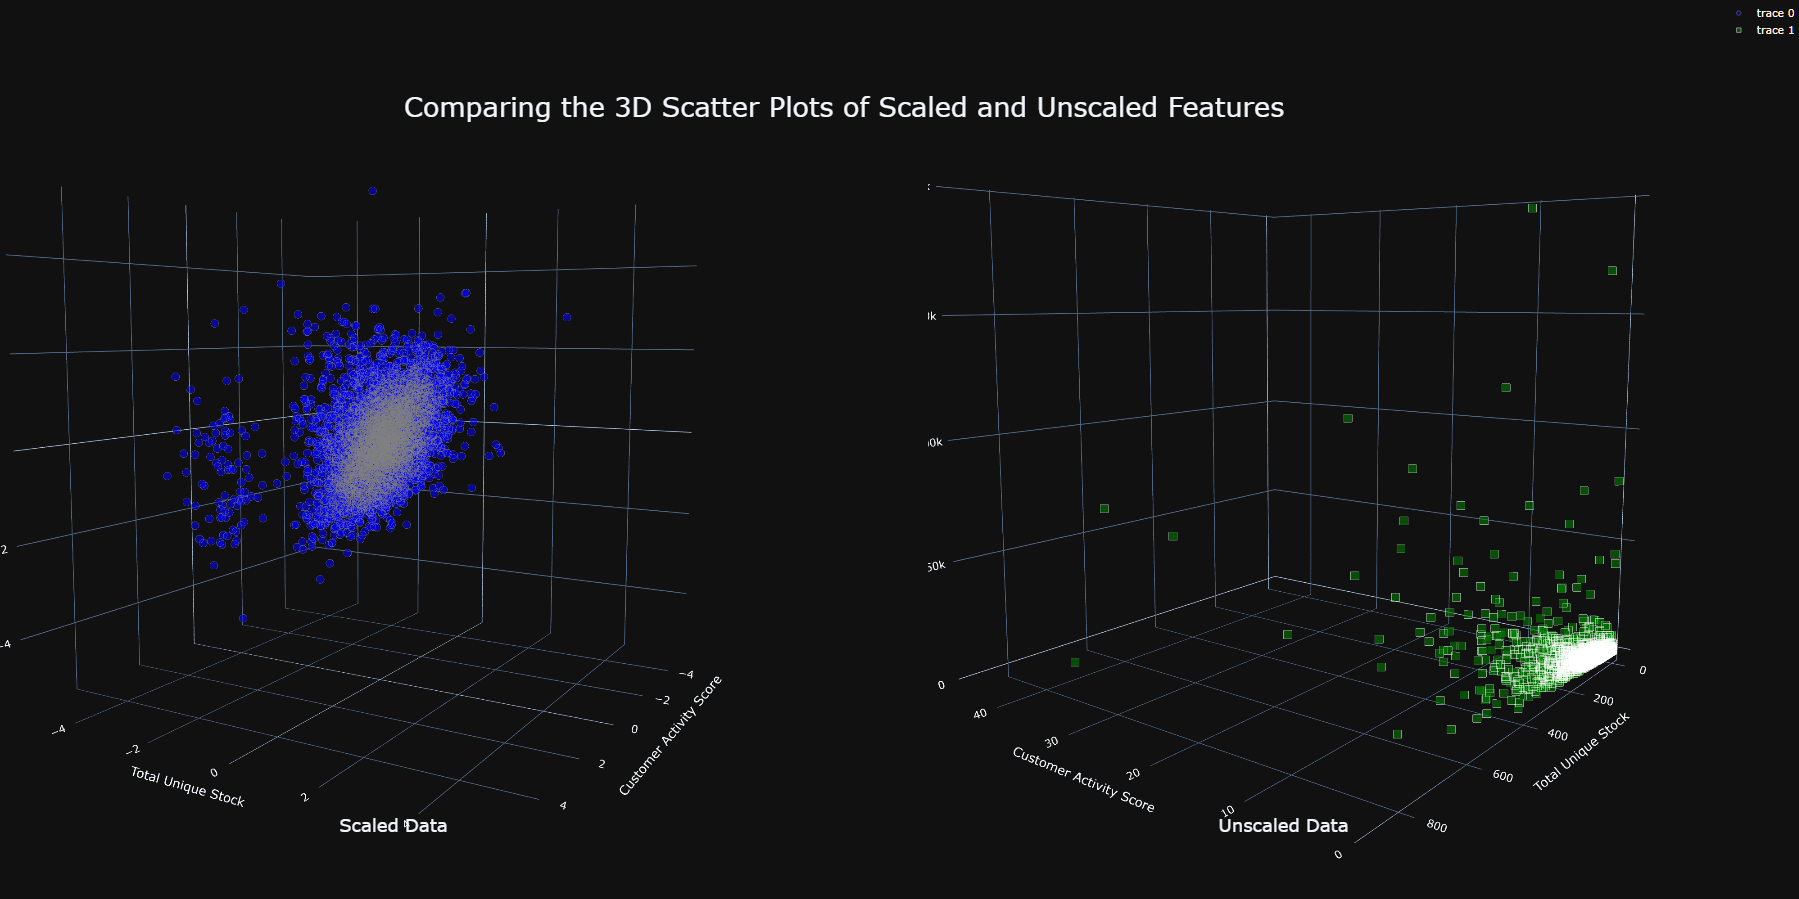

In [18]:
#Create some 3D scatterplots to visualize how scaling might affect our clustering attempt
fig = subplots.make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])


fig.add_trace(
    go.Scatter3d(
        x=np.array(customer_stats_scaled['customer_activity_score']),
        y=np.array(customer_stats_scaled['total_unique_stock']),
        z=np.array(customer_stats_scaled['total_purchases']),
        mode='markers',
        marker=dict(color='blue', symbol='circle', size=5, opacity=0.75,
                    line=dict(color='gray',width=1)),
        line=dict(color='white',width=2)
    ),
    row=1, col=1
)


fig.add_trace(
    go.Scatter3d(
        x=np.array(customer_stats_no_outliers['customer_activity_score']),
        y=np.array(customer_stats_no_outliers['total_unique_stock']),
        z=np.array(customer_stats_no_outliers['total_purchases']),
        mode='markers',
        marker=dict(color='green', symbol='square', size=5, opacity=0.75,
                    line=dict(color='white',width=1)),
    ),
    row=1, col=2
)

fig.update_layout( width=2000, height=1000, margin=dict(l=0, r=0, b=20, t=0), 
        annotations=[
            dict(text="Scaled Data",  x=0.20, y=.05, xref="paper", yref="paper", font=dict(size=20), showarrow=False),
            dict(text="Unscaled Data",  x=0.8, y=.05, xref="paper", yref="paper", font=dict(size=20), showarrow=False),
            dict(text="Comparing the 3D Scatter Plots of Scaled and Unscaled Features",  x=0.5, y=.9, xref="paper", yref="paper", font=dict(size=30), showarrow=False)],
        scene=dict(
            xaxis_title='Customer Activity Score',
            yaxis_title='Total Unique Stock',
            zaxis_title='Total Purchases'
    ),
        scene2=dict(
            xaxis_title='Customer Activity Score',
            yaxis_title='Total Unique Stock',
            zaxis_title='Total Purchases'
    ),
    )


#fig.write_html("plot.html")
Image('customer_seg_scaled_unscaled_clusters.png')


- Looking at the differences between the two 3D scatterplots, we can see better variance/dispersion with regards to the center in the scaled graph vs the unscaled graph, which should lead itself to more effective clustering attempts.

In [19]:
from sklearn.mixture import GaussianMixture 
import optuna

#Initialize a seed and X variable
seed = np.random.RandomState(seed=42)
X = customer_stats_scaled[['customer_activity_score', 'total_unique_stock', 'total_purchases']]


- We will be using a GaussianMixture Model that will incorporate the meeans produced by a base Gaussian Mixture, in order to initialize the starting points for our clusters which will enable our model to converge faster.

In [20]:
import optuna
from optuna.trial import Trial

def initial_means(n_components, method, seed, tol):
        model = GaussianMixture(
                n_components=n_components, init_params=method, tol=tol, max_iter=0, random_state=seed
            )
        model.fit(X)
        return model.means_

- All other parameters that will determine how clusters will be formed are tuned through Optuna, an optimization library that will help generate parameter values that produces the best fit. This is determined through the model's BIC score, lower numbers indicate a better fit.

- We will be tuning the number of components (essentially determining the number of clusters), the initialization method for our starting means, the tolerance threshold, and covariance type which will dictate how our clusters are formed and pick the set of parameters that produces the lowest BIC.

In [21]:

def objective(trial):
    method = trial.suggest_categorical('method', ["kmeans", "random_from_data", "k-means++", "random"])
    n_components = trial.suggest_int('n_components', 4,6)
    covariance_type = trial.suggest_categorical('covariance_type', ["spherical", "tied", "diag", "full"])
    tol = trial.suggest_float('tol', 5e-10, 1e-3, step=1e-10)
    #print(method, n_components, covariance_type)
    means = initial_means(n_components, method, seed, tol)

    model = GaussianMixture(
            n_components=n_components, means_init=means, covariance_type=covariance_type, tol=tol, max_iter=2000, random_state=seed, verbose=0
        )
    model.fit(X)
    
    score = model.bic(X)
    return score

samplertpe = optuna.samplers.TPESampler( n_startup_trials=10,  n_ei_candidates=15, multivariate=True, group=False)
study = optuna.create_study(directions=['minimize'], sampler=samplertpe)
study.optimize(objective, n_trials=250, n_jobs=1)
print(study.best_params)

c:\Users\eckz9\anaconda3\envs\NEWMLPROJECT\lib\site-packages\optuna\samplers\_tpe\sampler.py:250: ExperimentalWarning:

``multivariate`` option is an experimental feature. The interface can change in the future.

[I 2025-09-15 09:17:36,041] A new study created in memory with name: no-name-908d7488-1ad6-4eb5-8be0-f9f7f0e21c2b
[I 2025-09-15 09:17:36,100] Trial 0 finished with value: 34282.70740514024 and parameters: {'method': 'random', 'n_components': 4, 'covariance_type': 'tied', 'tol': 3.82251e-05}. Best is trial 0 with value: 34282.70740514024.
[I 2025-09-15 09:17:36,308] Trial 1 finished with value: 31655.023341253658 and parameters: {'method': 'random_from_data', 'n_components': 6, 'covariance_type': 'tied', 'tol': 0.00012476310000000002}. Best is trial 1 with value: 31655.023341253658.
[I 2025-09-15 09:17:36,386] Trial 2 finished with value: 32007.346826626203 and parameters: {'method': 'random', 'n_components': 6, 'covariance_type': 'spherical', 'tol': 6.24153e-05}. Best is trial

{'method': 'k-means++', 'n_components': 6, 'covariance_type': 'full', 'tol': 4.97899e-05}


In [22]:
#Use the parameters determined by our Optuna run to create a GaussianMixture model 
n = 6
c = 'full'
tol = 2.6042e-05


# 2. Define the saved "golden" means from your original run
saved_means = np.array([
    [-0.17910169,  0.21620388, -0.16714437],
    [ 1.02300326,  0.83200627,  1.05748728],
    [-1.1669186 , -5.19933758, -1.12914789],
    [-2.13168157, -0.19825847, -1.10891213],
    [-0.01881964, -1.61133325, -2.09181077],
    [-0.85167519, -0.61654097, -0.25417162]
])

# 3. Initialize the model, feeding it the SAVED means
model = GaussianMixture(
    n_components=n,
    means_init=saved_means,  # <-- This is the critical change
    covariance_type=c,
    tol=tol,
    max_iter=1000,
    random_state=seed,
    verbose=0,
    warm_start=True
)

# 4. Fit the model to your data
model.fit(X)

# 5. Verify the final means
# The output of this should be very close or identical to your 'saved_means'
print("--- Final Cluster Means ---")
print(model.means_)
#Printing the value of the means so that it can be saved to possibly create reproducable clustering attempts

--- Final Cluster Means ---
[[-0.04031506  0.1909102   0.17838766]
 [ 0.24487378  0.24121534  0.23330473]
 [-0.99708005 -5.19933758 -1.23357027]
 [-0.39471044 -0.19825847 -0.27266663]
 [-0.66099486 -0.95530555 -1.07640673]
 [-1.88659091 -0.56172419 -0.67678801]]


In [23]:
#Continue to refit the model for as many iterations needed until no further improvements on BIC occurs
for i in range(0,1000):
    model.fit(X)
        
    score = model.bic(X)
    score
    if i % 100 == 0:
        print(score)

29326.957676366277
29214.693144534926
29214.691034742325
29214.69103362332
29214.691033613177
29214.69103361304
29214.691033613035
29214.69103361303
29214.69103361303
29214.69103361303


In [24]:
import joblib

# Save the final, fitted model object to a file
#joblib.dump(model, 'final_gmm_model.pkl')
model = joblib.load('final_gmm_model.pkl')
print("\nModel successfully saved to 'final_gmm_model.pkl'")


Model successfully saved to 'final_gmm_model.pkl'


In [25]:
#Create a copy of our scaled X and add the label outputs generated by our model
X_copy = X.copy()
X_copy['Label'] = model.predict(X)
X_copy['Label'] = X_copy['Label'].astype(str)

- Lastly, we add the label column back to our unscaled dataframe so that we can generate some meaningful and interpretable analysis

In [26]:
label_dict = X_copy['Label'].to_dict()
customer_stats_no_outliers = customer_stats_no_outliers.reset_index()
customer_stats_no_outliers['label'] = customer_stats_no_outliers['index'].map(label_dict)
customer_stats_no_outliers = customer_stats_no_outliers.set_index('index')


In [79]:
customer_stats_no_outliers

,num_orders,num_order_days,days_since_last,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases,customer_activity_score,label
index,,,,,,,,,,,
13854,25.00,25.00,8.00,4.40,91.84,324.38,39.00,2296.00,8109.52,4.03,1
16903,1.00,1.00,29.00,50.00,262.00,373.24,50.00,262.00,373.24,0.11,5
17125,1.00,1.00,50.00,34.00,291.00,259.35,34.00,291.00,259.35,0.07,5
13328,1.00,1.00,316.00,17.00,680.00,1308.48,17.00,680.00,1308.48,0.01,5
12910,8.00,6.00,23.00,9.38,211.50,384.38,48.00,1692.00,3075.04,0.62,5
...,...,...,...,...,...,...,...,...,...,...,...
14082,1.00,1.00,364.00,28.00,110.00,182.25,28.00,110.00,182.25,0.01,5
16177,1.00,1.00,50.00,15.00,95.00,331.95,15.00,95.00,331.95,0.07,4
12508,2.00,2.00,26.00,32.00,136.00,199.13,57.00,272.00,398.27,0.19,5


- Here we select the columns related to the features we used for clustering. and display the summary statustics for the entire df, and every dataframe for each label in order to see if our model was able to create well defined and insightful segmentation between customer groups

In [77]:
# --- Create a Condensed Summary Table for the CORE CLUSTERS ---

# 1. (This part is from the previous step)
# Generate the describe() outputs and create the initial summary_df
desc_all = X_unscaled.describe()
desc_c0 = X0.describe()
desc_c1 = X1.describe()
desc_c5 = X5.describe()
summary_data_core = {
    'Overall': [desc_all.loc['count', 'num_orders'], desc_all.loc['mean', 'num_orders'], desc_all.loc['mean', 'days_since_last'], desc_all.loc['mean', 'total_unique_stock'], desc_all.loc['mean', 'total_purchases'], desc_all.loc['50%', 'total_purchases']],
    'Cluster 0': [desc_c0.loc['count', 'num_orders'], desc_c0.loc['mean', 'num_orders'], desc_c0.loc['mean', 'days_since_last'], desc_c0.loc['mean', 'total_unique_stock'], desc_c0.loc['mean', 'total_purchases'], desc_c0.loc['50%', 'total_purchases']],
    'Cluster 1': [desc_c1.loc['count', 'num_orders'], desc_c1.loc['mean', 'num_orders'], desc_c1.loc['mean', 'days_since_last'], desc_c1.loc['mean', 'total_unique_stock'], desc_c1.loc['mean', 'total_purchases'], desc_c1.loc['50%', 'total_purchases']],
    'Cluster 5': [desc_c5.loc['count', 'num_orders'], desc_c5.loc['mean', 'num_orders'], desc_c5.loc['mean', 'days_since_last'], desc_c5.loc['mean', 'total_unique_stock'], desc_c5.loc['mean', 'total_purchases'], desc_c5.loc['50%', 'total_purchases']]
}
summary_index = ['Count', 'Mean Orders', 'Mean Days Since Last', 'Mean Unique Stock', 'Mean Total Purchase (£)', 'Median Purchase (£)']
summary_df_core = pd.DataFrame(summary_data_core, index=summary_index)
persona_data_core = {'Overall': '---', 'Cluster 0': '(At-Risk)', 'Cluster 1': '(VIPs)', 'Cluster 5': '(Core Active)'}
persona_row_core = pd.DataFrame(persona_data_core, index=['Persona'])
final_summary_core = pd.concat([persona_row_core, summary_df_core])

# --- START: New code to force string formatting ---

# 2. Create a copy to format for display
formatted_summary_core = final_summary_core.copy()

# 3. Use .applymap() to convert every number to a formatted string
# This will force the viewer to display it correctly.
formatted_summary_core = formatted_summary_core.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)

# 4. Display the final, formatted table.
print("--- Summary of Core Customer Segments ---")
display(formatted_summary_core)

--- Summary of Core Customer Segments ---


C:\Users\eckz9\AppData\Local\Temp\ipykernel_5116\3044590063.py:28: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Overall,Cluster 0,Cluster 1,Cluster 5
Persona,---,(At-Risk),(VIPs),(Core Active)
Count,4328.00,1045.00,337.00,2263.00
Mean Orders,4.10,2.70,5.93,5.32
Mean Days Since Last,92.35,101.17,66.18,73.74
Mean Unique Stock,59.93,44.57,14.61,89.17
Mean Total Purchase (£),1839.06,901.45,4937.31,2247.97
Median Purchase (£),665.98,689.57,928.06,1006.98


In [78]:
# --- Create a Condensed Summary Table for the FRINGE CLUSTERS ---

# 1. (This part is from the previous step)
# Generate the describe() outputs and create the initial summary_df
desc_c2 = X2.describe()
desc_c3 = X3.describe()
desc_c4 = X4.describe()
summary_data_fringe = {
    'Overall': [desc_all.loc['count', 'num_orders'], desc_all.loc['mean', 'num_orders'], desc_all.loc['mean', 'days_since_last'], desc_all.loc['mean', 'total_unique_stock'], desc_all.loc['mean', 'total_purchases'], desc_all.loc['50%', 'total_purchases']],
    'Cluster 2': [desc_c2.loc['count', 'num_orders'], desc_c2.loc['mean', 'num_orders'], desc_c2.loc['mean', 'days_since_last'], desc_c2.loc['mean', 'total_unique_stock'], desc_c2.loc['mean', 'total_purchases'], desc_c2.loc['50%', 'total_purchases']],
    'Cluster 3': [desc_c3.loc['count', 'num_orders'], desc_c3.loc['mean', 'num_orders'], desc_c3.loc['mean', 'days_since_last'], desc_c3.loc['mean', 'total_unique_stock'], desc_c3.loc['mean', 'total_purchases'], desc_c3.loc['50%', 'total_purchases']],
    'Cluster 4': [desc_c4.loc['count', 'num_orders'], desc_c4.loc['mean', 'num_orders'], desc_c4.loc['mean', 'days_since_last'], desc_c4.loc['mean', 'total_unique_stock'], desc_c4.loc['mean', 'total_purchases'], desc_c4.loc['50%', 'total_purchases']]
}
summary_df_fringe = pd.DataFrame(summary_data_fringe, index=summary_index)
persona_data_fringe = {'Overall': '---', 'Cluster 2': '(Single Product)', 'Cluster 3': '(Churned)', 'Cluster 4': '(Niche)'}
persona_row_fringe = pd.DataFrame(persona_data_fringe, index=['Persona'])
final_summary_fringe = pd.concat([persona_row_fringe, summary_df_fringe])

# --- START: New code to force string formatting ---

# 2. Create a copy to format for display
formatted_summary_fringe = final_summary_fringe.copy()

# 3. Use .applymap() to convert every number to a formatted string
formatted_summary_fringe = formatted_summary_fringe.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)

# 4. Display the final, formatted table.
print("\n--- Summary of Fringe Customer Segments ---")
display(formatted_summary_fringe)


--- Summary of Fringe Customer Segments ---


C:\Users\eckz9\AppData\Local\Temp\ipykernel_5116\1916478881.py:25: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,Overall,Cluster 2,Cluster 3,Cluster 4
Persona,---,(Single Product),(Churned),(Niche)
Count,4328.00,94.00,14.00,575.00
Mean Orders,4.10,1.37,1.00,1.25
Mean Days Since Last,92.35,188.54,373.00,142.36
Mean Unique Stock,59.93,1.00,29.14,9.73
Mean Total Purchase (£),1839.06,1622.74,267.92,191.50
Median Purchase (£),665.98,170.10,260.31,169.55


In [39]:
X_unscaled = customer_stats_no_outliers[['num_orders', 'days_since_last', 'customer_activity_score', 'total_unique_stock', 'total_purchases', 'label']]
X_unscaled['label'] = X_unscaled['label'].astype(str)

X0 = X_unscaled[X_unscaled['label'] == '0']
X1 = X_unscaled[X_unscaled['label'] == '1']
X2 = X_unscaled[X_unscaled['label'] == '2']
X3 = X_unscaled[X_unscaled['label'] == '3']
X4 = X_unscaled[X_unscaled['label'] == '4']
X5 = X_unscaled[X_unscaled['label'] == '5']

print('Left: Main DF Statistics/Right: Cluster 1 Statistics')
display_side_by_side(X_unscaled.describe(), X1.describe())
print('-----------------------------------------------------')
print('Left: Cluster 0 Statistics/Right: Cluster 5 Statistics')
display_side_by_side(X0.describe(), X5.describe())

Left: Main DF Statistics/Right: Cluster 1 Statistics


,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,4328.00,4328.00,4328.00,4328.00,4328.00
mean,4.10,92.35,0.63,59.93,1839.06
std,5.93,100.19,1.86,72.15,6402.96
min,1.00,0.00,0.01,1.00,3.75
25%,1.00,17.00,0.04,16.00,305.28
50%,2.00,50.50,0.12,35.00,665.98
75%,5.00,142.25,0.44,77.00,1626.26
max,97.00,373.00,44.46,884.00,194550.79
,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,337.00,337.00,337.00,337.00,337.00


-----------------------------------------------------
Left: Cluster 0 Statistics/Right: Cluster 5 Statistics


,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,1045.00,1045.00,1045.00,1045.00,1045.00
mean,2.70,101.17,0.24,44.57,901.45
std,1.93,95.33,0.42,26.27,654.05
min,1.00,0.00,0.01,6.00,145.00
25%,1.00,28.00,0.03,24.00,425.27
50%,2.00,65.00,0.09,37.00,689.57
75%,4.00,159.00,0.25,57.00,1145.84
max,14.00,372.00,4.22,171.00,4873.81
,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,2263.00,2263.00,2263.00,2263.00,2263.00


These first three clusters are what we can consider to be our core customer base split up into 3 different segments all of different qualities. 

- Cluster 1 is the biggest cluster out of the 6, and more importantly outperforms all others, including the averages produced by the entire dataframe. This is an important segment of customers that need to be focused on and further analyze as on average, they have higher total purchases, purchase a wider variety of products, have placed an order recently, and have placed more orders overall as a group. This group is essentially the lifeblood of the business and analyzing the trends and habits of this customer segment is vital for the future of the business

- Cluster 0 while comparable to cluster 1 in size, does fall behind in all the other key columns. Still, the averages of this group are close to the overall averages of the entire customer base, which makes this population a good representative of the whole, and analyzing the differences of this Cluster with both Cluster 1 and the entire customer population will help in gaining insight of what helps in maintaining a healtlhy base of customers with regards to the latter, and possibly help identify what drives further growth with regards to the former.

- Cluster 5 Is the lowest performing major cluster, and could represent customers that have either stopped doing business, are customers located outside of the United Kingdom or are new customers that are still testing things out. Analyzing this group could be important to understanding churn and developing an e business environment that is conducive to customer retention, or if they are located out of the country - how more international customers can be reached.   

In [29]:

c1_percent = X5["total_purchases"].sum()/X_unscaled["total_purchases"].sum()*100
X5_no_outliers = X5[X5['total_purchases'] < stats_df.loc['99%', 'total_purchases']]
c1_percent2 = X5_no_outliers['total_purchases'].sum()/X_unscaled['total_purchases'].sum()*100
f'Cluster 5 makes up {c1_percent:.2f}% of all total sales overall, and after filtering all accounts above the 99th percentile (representing possible outliers), still represents {c1_percent2:.2f}% of all sales' 

'Cluster 5 makes up 63.91% of all total sales overall, and after filtering all accounts above the 99th percentile (representing possible outliers), still represents 52.35% of all sales'

In [30]:
print('Left: Main DF Statistics/Right: Cluster 3 Statistics')
display_side_by_side(X_unscaled.describe(), X3.describe())
print('-----------------------------------------------------')
print('Left: Cluster 2 Statistics/Right: Cluster 4 Statistics')
display_side_by_side(X2.describe(), X4.describe())

Left: Main DF Statistics/Right: Cluster 3 Statistics


,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,4328.00,4328.00,4328.00,4328.00,4328.00
mean,4.10,92.35,0.63,59.93,1839.06
std,5.93,100.19,1.86,72.15,6402.96
min,1.00,0.00,0.01,1.00,3.75
25%,1.00,17.00,0.04,16.00,305.28
50%,2.00,50.50,0.12,35.00,665.98
75%,5.00,142.25,0.44,77.00,1626.26
max,97.00,373.00,44.46,884.00,194550.79
,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,14.00,14.00,14.00,14.00,14.00


-----------------------------------------------------
Left: Cluster 2 Statistics/Right: Cluster 4 Statistics


,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,94.00,94.00,94.00,94.00,94.00
mean,1.37,188.54,0.08,1.00,1622.74
std,0.83,116.41,0.17,0.00,8895.01
min,1.00,2.00,0.01,1.00,3.75
25%,1.00,89.25,0.01,1.00,71.40
50%,1.00,191.50,0.02,1.00,170.10
75%,1.00,293.00,0.05,1.00,440.00
max,5.00,373.00,1.28,1.00,77183.60
,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,575.00,575.00,575.00,575.00,575.00


- The last 3 clusters are all fringe clusters representing different specific customer segments - with Cluster 2 being the group with the lowest unique stock purchases (actually only a single individual stock), Cluster 3 comprising of single order counts and longest days since last order, while Cluster 4 representing an interesting segment that purchases a specific combination of items in varying degrees of frequency and dollar values. 
- As a whole these clusters constitute a small segment of the business, but some insights might still be gained by identifying what individual or group of items bring certain customers (similar to those in Cluster 4 and 2) to the online storefront, as continuing to provide the same or similar products could help with customer retention.

In [31]:
c234_percent = (X3["total_purchases"].sum()+X2["total_purchases"].sum()+X4["total_purchases"].sum()) /X_unscaled["total_purchases"].sum()*100
c234_percent_order = (X3["num_orders"].sum()+X2["num_orders"].sum()+X4["num_orders"].sum()) /X_unscaled["num_orders"].sum()*100

f'Cluster 2,3 and 4 combined make up {c234_percent:.2f}% of all total sales overall, and {c234_percent_order:.2f}% of all business volume in terms of orders'

'Cluster 2,3 and 4 combined make up 3.35% of all total sales overall, and 4.86% of all business volume in terms of orders'

In [32]:
# --- Final GMM Visualization (Scaled Data, Core vs. Fringe) ---

# 1. Prepare the data by splitting into core and fringe groups
X_copy1 = X_copy[X_copy['Label'].isin(['0','1','5'])]
X_copy1['color'] = X_copy1['Label'].astype(int)

X_copy2 = X_copy[X_copy['Label'].isin(['2','3','4'])]
X_copy2['color'] = X_copy2['Label'].astype(int)

# 2. Create the 1x2 subplot figure
# We will use this single figure object for all subsequent steps
fig_gmm_final = subplots.make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=('GMM Core Clusters', 'GMM Fringe Clusters')
)

# 3. Define color and symbol maps
color_map = { 0:'#4ad9b4', 1:'#2474b7',  5:'#ef553b', 4:'#00cc96', 2:'#1dd6c9', 3:'#ef553b',} 
symbol_map = {0: 'diamond', 1:'square',  5:'circle',  4: 'circle', 2:'x', 3:'square', } 

# 4. Add the data traces for the CORE plot to fig_gmm_final
for label in set(X_copy1['color']):
    mask = np.array(X_copy1['color']) == label
    fig_gmm_final.add_trace( # <-- Add trace to the correct figure
        go.Scatter3d(
            x=np.array(X_copy1['customer_activity_score'])[mask],
            y=np.array(X_copy1['total_unique_stock'])[mask], 
            z=np.array(X_copy1['total_purchases'])[mask],
            mode='markers',
            marker=dict(color=color_map[label], symbol=symbol_map[label], size=7, opacity=0.55),
            name=f'GMM Cluster {label}'
        ),
        row=1, col=1
    )

# 5. Add the data traces for the FRINGE plot to fig_gmm_final
for label in set(X_copy2['color']):
    mask = np.array(X_copy2['color']) == label
    fig_gmm_final.add_trace( # <-- Add trace to the correct figure
        go.Scatter3d(
            x=np.array(X_copy2['customer_activity_score'])[mask],
            y=np.array(X_copy2['total_unique_stock'])[mask],
            z=np.array(X_copy2['total_purchases'])[mask],
            mode='markers',
            marker=dict(color=color_map[label], symbol=symbol_map[label], size=7, opacity=0.55),
            name=f'GMM Cluster {label}'
        ),
        row=1, col=2
    )

# 6. Update the layout of fig_gmm_final with all formatting
fig_gmm_final.update_layout(
    title_text="Customer Segmentation Comparison: GMM Results (on Scaled Data)",
    width=1700, height=900,
    margin=dict(l=0, r=0, b=20, t=80),
    title_font_size=30,
    font=dict(size=14),
    scene=dict(
        domain=dict(x=[0, 0.5], y=[0, 1]),
        xaxis_title='Customer Activity Score',
        yaxis_title='Total Unique Stock',
        zaxis_title='Total Purchases',
        aspectmode='manual',
        aspectratio=dict(x=1.5, y=1.5, z=1),
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        zaxis_title_font_size=18,
        xaxis_tickfont_size=12,
        yaxis_tickfont_size=12,
        zaxis_tickfont_size=12
    ),
    scene2=dict(
        domain=dict(x=[0.51, 1.0], y=[0, 1]),
        xaxis_title='Customer Activity Score',
        yaxis_title='Total Unique Stock',
        zaxis_title='Total Purchases',
        aspectmode='manual',
        aspectratio=dict(x=1.5, y=1.5, z=1),
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        zaxis_title_font_size=18,
        xaxis_tickfont_size=12,
        yaxis_tickfont_size=12,
        zaxis_tickfont_size=12
    ),
    legend=dict(
        font_size=16
    )
)

for anno in fig_gmm_final.layout.annotations:
    anno.y = 0.90  # The default is ~0.98. Lower this value to move the titles down.
    anno.yanchor = 'bottom' # Anchors the bottom of the text to the y-coordinate
# --- END: New code ---




# 7. Show the final, complete figure
fig_gmm_final.show()

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --- K-Means Baseline Model ---
# We will use the same number of clusters as the GMM for a direct comparison.
n_clusters_kmeans = 6 

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X)

print("K-Means clustering complete.")

#### **Step 4: Get the Labels from Your GMM (You've already done this)**


# This is from your existing code
gmm_labels = model.predict(X)
print("GMM predictions complete.")
# --- Quantitative Evaluation ---

# 1. Calculate scores for K-Means
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(X, kmeans_labels)

# 2. Calculate scores for GMM
gmm_silhouette = silhouette_score(X, gmm_labels)
gmm_davies_bouldin = davies_bouldin_score(X, gmm_labels)

# 3. Create a comparison table
results_data = {
    'K-Means': [kmeans_silhouette, kmeans_davies_bouldin],
    'GMM': [gmm_silhouette, gmm_davies_bouldin]
}
results_df = pd.DataFrame(results_data, index=['Silhouette Score (Higher is Better)', 'Davies-Bouldin Score (Lower is Better)'])

print("--- Cluster Evaluation Metrics ---")
display(results_df)

K-Means clustering complete.
GMM predictions complete.
--- Cluster Evaluation Metrics ---


,K-Means,GMM
Silhouette Score (Higher is Better),0.27,0.02
Davies-Bouldin Score (Lower is Better),1.05,1.90


In [34]:

# --- Final K-Means Visualization (Scaled Data, Core vs. Fringe) ---

# 1. Create a copy of the scaled data and add the K-Means labels
X_kmeans_copy = X.copy()
X_kmeans_copy['KMeans_Label'] = kmeans_labels
X_kmeans_copy['KMeans_Label'] = X_kmeans_copy['KMeans_Label'].astype(str)

# 2. IMPORTANT: Analyze the .describe() output for each K-Means cluster
# and update the lists below with the correct labels for YOUR results.
kmeans_core_labels = ['0', '1', '5']  # <-- CONFIRM THIS based on your analysis
kmeans_fringe_labels = ['2', '3', '4'] # <-- CONFIRM THIS based on your analysis

# 3. Split the scaled data into core and fringe groups
kmeans_core_df = X_kmeans_copy[X_kmeans_copy['KMeans_Label'].isin(kmeans_core_labels)]
kmeans_fringe_df = X_kmeans_copy[X_kmeans_copy['KMeans_Label'].isin(kmeans_fringe_labels)]

# 4. Create the 1x2 subplot figure
fig_kmeans_final = subplots.make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=('K-Means Core Clusters', 'K-Means Fringe Clusters')
)

# 5. Define color and symbol maps
color_map = { 0:'#4ad9b4', 1:'#ef553b', 2:'#ab63fa', 3:'#00cc96', 4:'#ef553b', 5:'#ab63fa'} 
symbol_map = {0: 'circle', 1:'circle', 2:'circle', 3: 'circle', 4:'circle', 5:'circle' }

# 6. Add the data traces for the CORE plot
for label_str in kmeans_core_labels:
    label_int = int(label_str)
    mask = kmeans_core_df['KMeans_Label'] == label_str
    fig_kmeans_final.add_trace(
        go.Scatter3d(
            x=kmeans_core_df[mask]['customer_activity_score'],
            y=kmeans_core_df[mask]['total_unique_stock'], 
            z=kmeans_core_df[mask]['total_purchases'],
            mode='markers',
            marker=dict(color=color_map[label_int], symbol=symbol_map[label_int], size=5, opacity=0.7),
            name=f'K-Means Cluster {label_str}'
        ),
        row=1, col=1
    )

# 7. Add the data traces for the FRINGE plot
for label_str in kmeans_fringe_labels:
    label_int = int(label_str)
    mask = kmeans_fringe_df['KMeans_Label'] == label_str
    fig_kmeans_final.add_trace(
        go.Scatter3d(
            x=kmeans_fringe_df[mask]['customer_activity_score'],
            y=kmeans_fringe_df[mask]['total_unique_stock'],
            z=kmeans_fringe_df[mask]['total_purchases'],
            mode='markers',
            marker=dict(color=color_map[label_int], symbol=symbol_map[label_int], size=5, opacity=0.7),
            name=f'K-Means Cluster {label_str}'
        ),
        row=1, col=2
    )

# 8. --- Final Layout Update for K-Means Plot ---
# This block is identical to the GMM layout for perfect uniformity.
fig_kmeans_final.update_layout(
    title_text="Customer Segmentation Comparison: K-Means Results (on Scaled Data)", # <-- Title changed
    width=2000, height=900,
    margin=dict(l=0, r=0, b=20, t=80),
    title_font_size=30,
    font=dict(size=14),
    scene=dict(
        domain=dict(x=[0, 0.5], y=[0, 1]),
        xaxis_title='Customer Activity Score',
        yaxis_title='Total Unique Stock',
        zaxis_title='Total Purchases',
        aspectmode='manual',
        aspectratio=dict(x=1.5, y=1.5, z=1),
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        zaxis_title_font_size=18,
        xaxis_tickfont_size=12,
        yaxis_tickfont_size=12,
        zaxis_tickfont_size=12
    ),
    scene2=dict(
        domain=dict(x=[0.51, 1.0], y=[0, 1]),
        xaxis_title='Customer Activity Score',
        yaxis_title='Total Unique Stock',
        zaxis_title='Total Purchases',
        aspectmode='manual',
        aspectratio=dict(x=1.5, y=1.5, z=1),
        xaxis_title_font_size=18,
        yaxis_title_font_size=18,
        zaxis_title_font_size=18,
        xaxis_tickfont_size=12,
        yaxis_tickfont_size=12,
        zaxis_tickfont_size=12
    ),
    legend=dict(
        font_size=16
    )
)

# 9. Adjust subplot title positions to match the GMM plot
for anno in fig_kmeans_final.layout.annotations:
    anno.y = 0.90
    anno.yanchor = 'bottom'

# 10. Show the final, complete figure
fig_kmeans_final.show()



In [35]:
#The code below creates a 3D Scatterplot that visualizes the difference between the 3 major clusters and the 3 minor clusters.

X_copy1 = X_copy[X_copy['Label'].isin(['0','1','5'])]
X_copy1['color'] = X_copy1['Label'].astype(int)

X_copy2 = X_copy[X_copy['Label'].isin(['2','3','4'])]
X_copy2['color'] = X_copy2['Label'].astype(int)
fig = subplots.make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# Define a color map for the clusters
color_map = { 0:'#4ad9b4', 1:'#ef553b',  5:'#2474b7', 4:'#00cc96', 2:'#1dd6c9', 3:'#ef553b',} 
symbol_map = {0: 'diamond', 1:'square',  5:'circle',  4: 'circle', 2:'x', 3:'square', } 

# Create a trace for each unique cluster label in the first plot
for label in set(X_copy1['color']):
    mask = np.array(X_copy1['color']) == label
    fig.add_trace(
        go.Scatter3d(
            x=np.array(X_copy1['customer_activity_score'])[mask],
            y=np.array(X_copy1['total_unique_stock'])[mask],
            z=np.array(X_copy1['total_purchases'])[mask],
            mode='markers',
            marker=dict(color=color_map[label], symbol=symbol_map[label], size=7, opacity=0.55,
                        line=dict(color='gray',width=1)),
            line=dict(color='white',width=2),
            name=f'Cluster {label}'
        ),
        row=1, col=1
    )

# Create a trace for each unique cluster label in the second plot
for label in set(X_copy2['color']):
    mask = np.array(X_copy2['color']) == label
    fig.add_trace(
        go.Scatter3d(
            x=np.array(X_copy2['customer_activity_score'])[mask],
            y=np.array(X_copy2['total_unique_stock'])[mask],
            z=np.array(X_copy2['total_purchases'])[mask],
            mode='markers',
            marker=dict(color=color_map[label], symbol=symbol_map[label], size=7, opacity=0.55,
                        line=dict(color='white',width=1)),
            name=f'Cluster {label}'
        ),
        row=1, col=2
    )


# Update layout

fig.update_layout( width=2000, height=1000, margin=dict(l=0, r=0, b=20, t=0), 
        annotations=[
            dict(text="Core Clusters (0, 1, 5)",  x=0.20, y=.05, xref="paper", yref="paper", font=dict(size=20), showarrow=False),
            dict(text="Fringe Clusters (2, 3, 4)",  x=0.8, y=.05, xref="paper", yref="paper", font=dict(size=20), showarrow=False)],
        scene=dict(
            xaxis_title='Customer Activity Score',
            yaxis_title='Total Unique Stock',
            zaxis_title='Total Purchases'
    ),
        scene2=dict(
            xaxis_title='Customer Activity Score',
            yaxis_title='Total Unique Stock',
            zaxis_title='Total Purchases'
    ),
    )

fig.update_traces(marker=dict(opacity=0.35), selector=dict(name='Cluster 1'))
fig.update_traces(marker=dict(opacity=.9), selector=dict(name='Cluster 0'))

# Show the figure
#fig.show()
Image('clust3.png')

FileNotFoundError: No such file or directory: 'clust3.png'

FileNotFoundError: No such file or directory: 'clust3.png'

<IPython.core.display.Image object>